In [1]:
# NN packages
import jax
import jax.numpy as jnp
import optax
import numpy as np
import json

# Visualization packages
import matplotlib.pyplot as plt

# ML Models
from LNN.models.MDOF_LNN import Physical_Damped_LNN, Modal_MLP

# Helper functions
from LNN.helpers import save_to_file, create_modal_training_data, plot_S_curves, plot_3DS_curves

from lnn_timesim import time_sim_branch, run

#### LNN


In [2]:
filename='frequency_step_frequency_'
path='LNN/Conx/modal'
start=10.0
stop=24.0
step=0.2

ml_data = save_to_file(filename=filename, path=path, start=start, stop=stop, step=step, check=True)

train_data, test_data, info = create_modal_training_data(ml_data, path, split=0.2, seed=42)

Data saved to LNN/Conx/modal/data.pkl
Number of files: 71

---EXAMPLE SHAPES---
pose: (2, 301, 39), vel: (2, 301, 39), acc: (2, 301, 39)
If MODAL: 2 Modes, 301 time steps per 39 points along curve
If PHYSICAL: 301 time steps per 39 points along curve
time: (301, 39), F: (39,), T: (39,), force: (2, 301, 39)
Training data shape: (805175, 2, 4), Testing data shape: (207389, 2, 4)
Samples, # of Modes, [x, dx, ddx, force]
x_train.shape: (805175, 2), dx_train.shape: (805175, 2), ddx_train.shape: (805175, 2), force_train.shape: (805175, 2)
x_test.shape: (207389, 2), dx_test.shape: (207389, 2), ddx_test.shape: (207389, 2), force_test.shape: (207389, 2)


In [3]:
mnn_settings = {
    'name': 'MNN',
    'units': 64,
    'layers': 4,
    'input_shape': 4,
    'train_batch_size': 128,
    'test_batch_size': 16,
    'shuffle': True,
    'seed': 69
    }

knn_settings = {
    'name': 'KNN',
    'units': 64,
    'layers': 4,
    'input_shape': 4,
    }

dnn_settings = {
    'name': 'DNN',
    'units': 32,
    'layers': 4,
    'input_shape': 2,
    }

lr = 1e-03
mnn_optimizer = optax.adam(lr)
knn_optimizer = optax.adam(lr)
dnn_optimizer = optax.adam(lr)
epochs = 20
show_every = 10

In [4]:
a = Physical_Damped_LNN(
    mnn_module=Modal_MLP, 
    knn_module=Modal_MLP,       
    dnn_module=Modal_MLP, 
    mnn_settings=mnn_settings,
    knn_settings=knn_settings,
    dnn_settings=dnn_settings, 
    mnn_optimizer=mnn_optimizer, 
    knn_optimizer=knn_optimizer, 
    dnn_optimizer=dnn_optimizer, 
    info=info, 
    activation=jax.nn.tanh)

# Start training LNN
results = None
_, _, _ = a.gather()

In [5]:
results_path = 'MDOF_LNN'
file_name='Modal'
iter_num = 200

epochs = 20
show_every = 10

In [6]:
results = Physical_Damped_LNN.load_model(f"./LNN/{results_path}/{file_name}/Iter_{iter_num}/model.pkl")

In [7]:
pred_acc_, pred_energy = a._predict(results)

#### NOTES:
- $16.0$ Hz doesn't start - to investigate
- $18.6$ Hz fails after a few steps - to investigate



Iter Cont     Iter Corr     Residual      Freq          Amp           Energy        Step          Beta          
0             0             6.9324e-03    18.6000       0.5000        0.0000e+00                                
0             1             1.5814e-04    18.6000       0.5000        0.0000e+00                                
0             2             1.7480e-07    18.6000       0.5000        0.0000e+00                                


/home/aax23/PyCont_release/core/logger.py:201: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.pause(0.01)


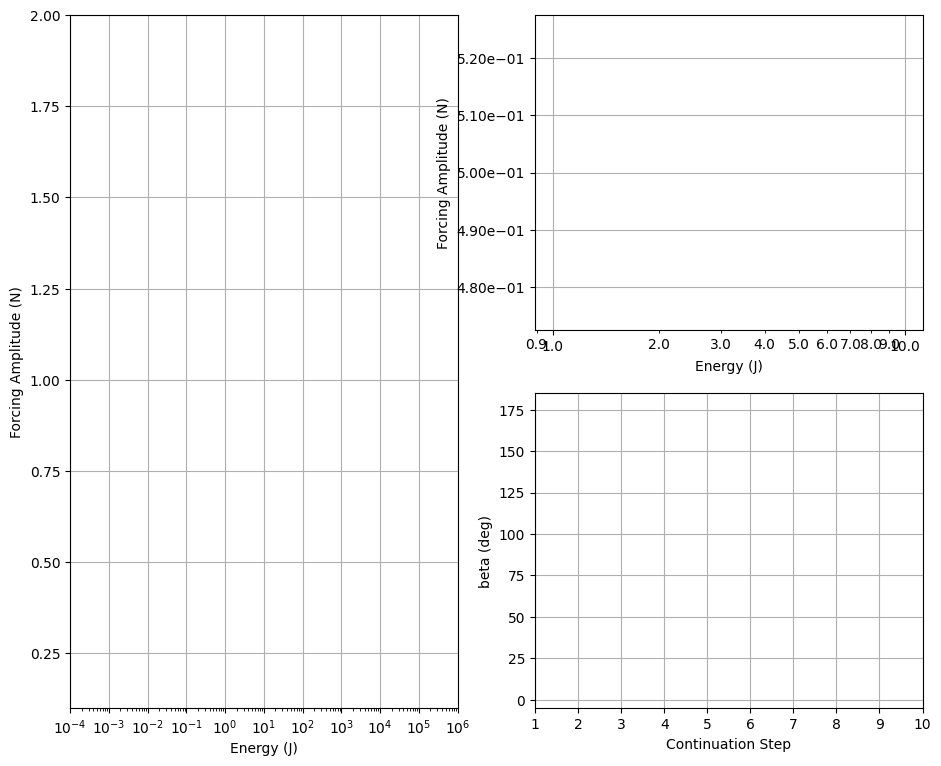

----------------------------------------------------------------------------------------------------------------
1             0             4.2510e-07    18.6000       0.5001        0.0000e+00    1.000e-04                   
1             1             3.4095e-07    18.6000       0.5001        0.0000e+00    1.000e-04     0.0000        
----------------------------------------------------------------------------------------------------------------


/home/aax23/PyCont_release/core/logger.py:217: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.fig.tight_layout()


2             0             4.8330e-07    18.6000       0.5002        0.0000e+00    1.000e-04                   
2             1             2.7792e-07    18.6000       0.5002        0.0000e+00    1.000e-04     0.0000        
----------------------------------------------------------------------------------------------------------------
3             0             3.0074e-07    18.6000       0.5004        0.0000e+00    2.000e-04                   
3             1             1.5114e-07    18.6000       0.5004        0.0000e+00    2.000e-04     0.0000        
----------------------------------------------------------------------------------------------------------------
4             0             3.6847e-07    18.6000       0.5008        0.0000e+00    4.000e-04                   
4             1             3.7397e-07    18.6000       0.5008        0.0000e+00    4.000e-04     0.0001        
------------------------------------------------------------------------------------------------

In [ ]:
cont_params_file = 'contparameters.json'
i = 18.6
# Open contparameters.json
with open(cont_params_file, 'r') as file:
    data = json.load(file)
    # Modify forcing frequency
    data['forcing']['frequency'] = i
    # Save file
    data['Logger']['file_name'] = f'freq_step_{i:.02f}'

# Modify contparameters.json
with open(cont_params_file, 'w') as file:
    json.dump(data, file, indent=2)

# Run simulation
run(pred_acc=pred_acc_)

# Perform time-sim post-processing
time_sim_branch(file=f'freq_step_{i:.02f}', inplace="-i", run_bif="n", store_physical="n")

In [ ]:
cont_params_file = 'contparameters.json'
for i in np.arange(19.0, 24.1, 0.2):
    # Open contparameters.json
    with open(cont_params_file, 'r') as file:
        data = json.load(file)
        # Modify forcing frequency
        data['forcing']['frequency'] = i
        # Save file
        data['Logger']['file_name'] = f'freq_step_{i:.02f}'

    # Modify contparameters.json
    with open(cont_params_file, 'w') as file:
        json.dump(data, file, indent=2)
    
    # Run simulation
    run(pred_acc=pred_acc_)
    
    # Perform time-sim post-processing
    time_sim_branch(file=f'freq_step_{i:.02f}', inplace="-i", run_bif="n", store_physical="n")